In [1]:
import os
import csv
import sys
import json
import random
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import roc_auc_score

from collections import defaultdict

%matplotlib inline

In [2]:
sys.path.append('../src')
import plot_helpers as ph
pd.set_option('display.precision', 3)

In [3]:
experiment_id = "4A"
experiment = json.load(open('../analysis.json'))["experiments"][experiment_id]

In [4]:
from IPython.display import Markdown as md
md(f"""
## {experiment['name']}

### Description
{experiment['description']}

### Results
In this version, all sections perform best when trained on all data. Adverse Reactions do perform slightly better
when predicted from training on the Adverse Reactions section. 
Boxed Warnings and Warnings and Precautions perform best when trained on all sections together. 
""")


## Compare performance across AR, BW, and WP sections, method 14 (prepend refsource, 87.5 After)

### Description
Compare performance for each of the sections: Adverse Reactions (AR), Boxed Warnings (BW), and Warnings and Precautions (WP). For this experiment we train all of them independently from the pre-trained ClinicalBERT network. Also compare grouping all of the sections together. We may see improved performance of the lower frequency sections in this scenario.

### Results
In this version, all sections perform best when trained on all data. Adverse Reactions do perform slightly better
when predicted from training on the Adverse Reactions section. 
Boxed Warnings and Warnings and Precautions perform best when trained on all sections together. 


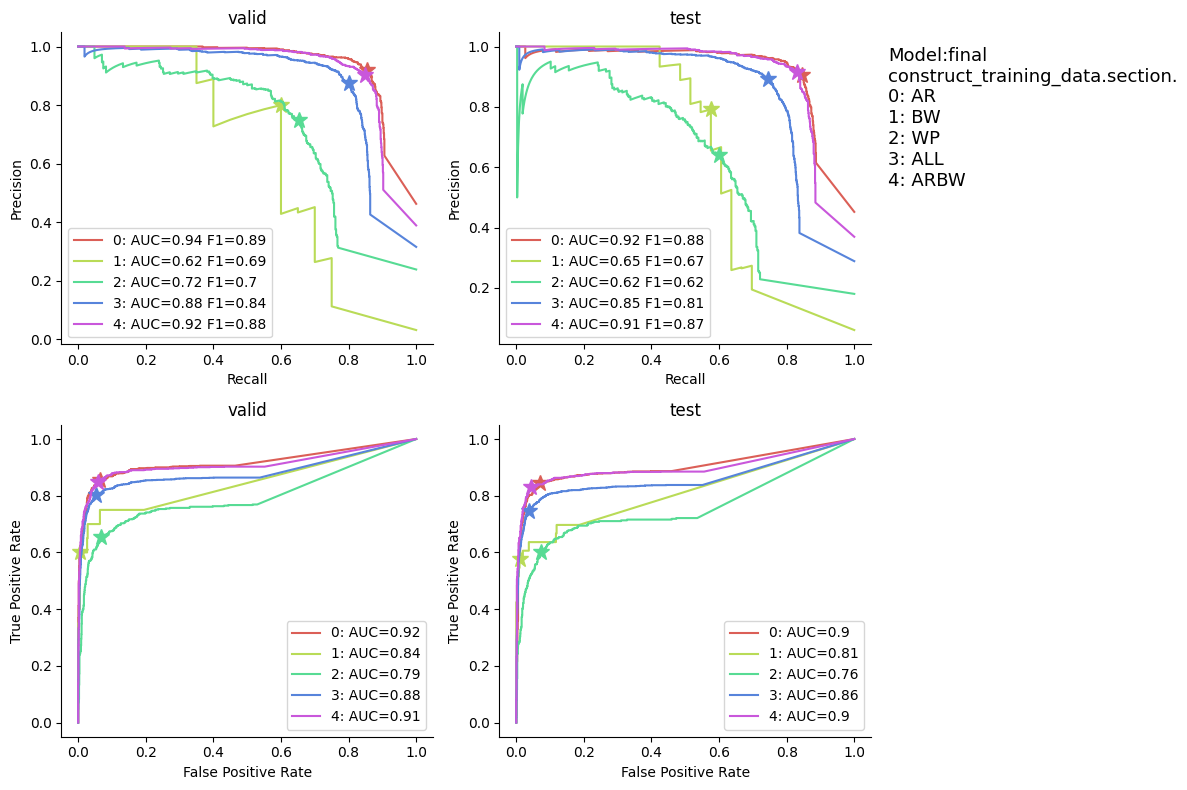

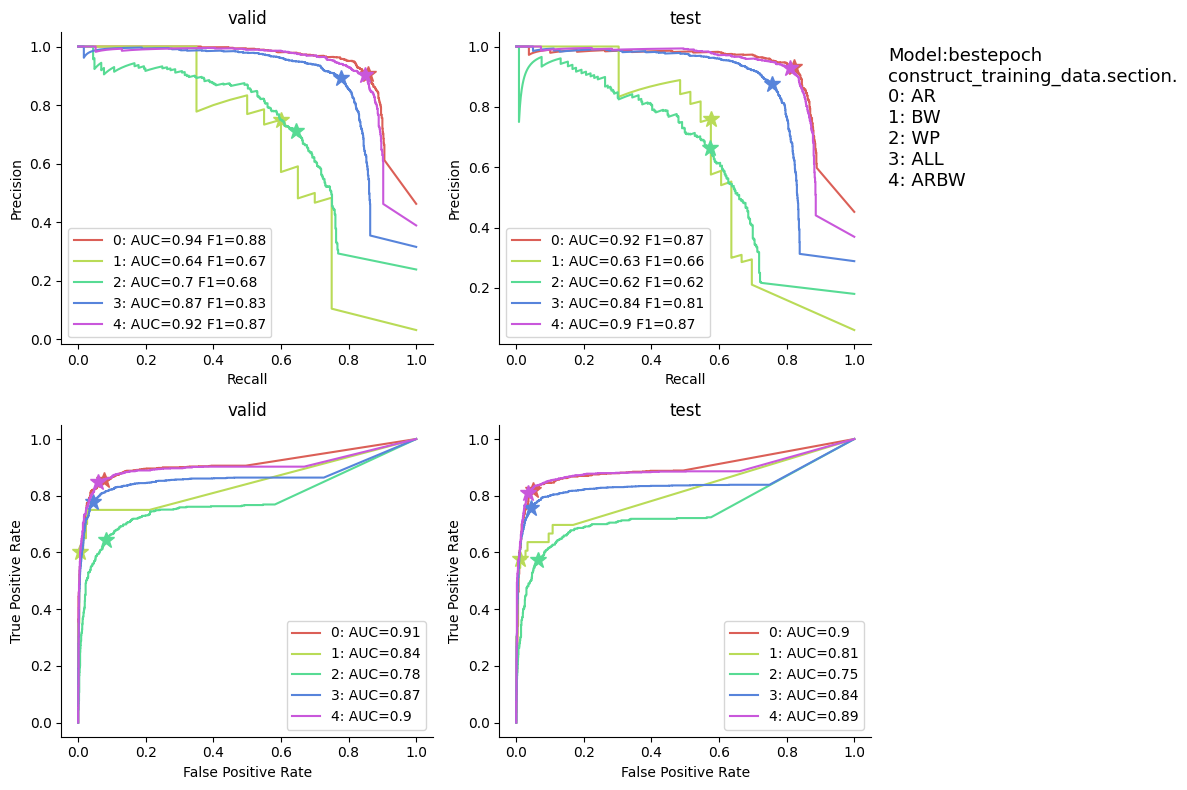

In [5]:
perfdata = defaultdict(lambda: defaultdict(list))

factor_labels = list()

for modeltype in ('final', 'bestepoch'):
    resfiles = experiment[modeltype]
    colors = sns.color_palette("hls", len(resfiles))

    plt.figure(figsize=(12,8))
    plotcounter = 1


    for split in ('valid', 'test'):
        plt.subplot(2, 2, plotcounter)
        plotcounter += 1
        plt.title(split)

        for i, resfile in enumerate(resfiles):

            df = pd.read_csv(os.path.join('..', resfile), index_col=0)
            df['label'] = [1 if c == 'is_event' else 0 for c in df['class']]
            split_df = df[df['split']==split]

            prdata = ph.prdata(split_df['label'], split_df['Pred1'])
            perfdata[(modeltype, split)]['prdata'].append(prdata)
            
            plt.plot(prdata['recall'], prdata['precision'], color=colors[i], 
                     label=f'{i}: AUC={prdata["pr_auc"]:.2} F1={prdata["max_f1"]:.2}'
                    )
            plt.plot([prdata['max_f1_recall']], [prdata['max_f1_precision']], '*', color=colors[i], markersize=12)
            
            if modeltype == 'final' and split == 'valid':
                factor_labels.append(experiment['labels'][i])
            
            # Special processing for the ALL sections file
            sections = []
            if 'ALL' in resfile:
                sections = ('AR', 'BW', 'WP')
                groupname = 'ALL'
            elif 'ARBW' in resfile:
                sections = ('AR', 'BW')
                groupname = 'ARBW'
            
            if len(sections) > 0:
                for section in sections:
                    section_df = split_df[split_df['section'] == section]
                    section_prdata = ph.prdata(section_df['label'], section_df['Pred1'])
                    perfdata[(modeltype, split)]['prdata'].append(section_prdata)
                    if modeltype == 'final' and split == 'valid':
                        factor_labels.append(f'{section}-{groupname}')


        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        sns.despine()

    for split in ('valid', 'test'):
        plt.subplot(2, 2, plotcounter)
        plotcounter += 1
        plt.title(split)

        for i, resfile in enumerate(resfiles):

            df = pd.read_csv(os.path.join('..', resfile), index_col=0)
            df['label'] = [1 if c == 'is_event' else 0 for c in df['class']]
            split_df = df[df['split']==split]

            prdata = ph.prdata(split_df['label'], split_df['Pred1'])
            rocdata = ph.rocdata(split_df['label'], split_df['Pred1'], prdata['max_f1_threshold'])
            perfdata[(modeltype, split)]['rocdata'].append(rocdata)
            
            plt.plot(rocdata['fpr'], rocdata['tpr'], color=colors[i], 
                     label=f'{i}: AUC={rocdata["roc_auc"]:.2}'
                    )
            plt.plot([rocdata['max_f1_fpr']], [rocdata['max_f1_tpr']], '*', color=colors[i], markersize=12)
            
            # Special processing for the ALL sections file
            sections = []
            if 'ALL' in resfile:
                sections = ('AR', 'BW', 'WP')
                groupname = 'ALL'
            elif 'ARBW' in resfile:
                sections = ('AR', 'BW')
                groupname = 'ARBW'
            
            if len(sections) > 0:
                for section in sections:
                    section_df = split_df[split_df['section'] == section]
                    section_rocdata = ph.rocdata(section_df['label'], section_df['Pred1'], prdata['max_f1_threshold'])
                    perfdata[(modeltype, split)]['rocdata'].append(section_rocdata)

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        sns.despine()

    plt.subplot(2, 2, 2)
    reflegend = f'Model:{modeltype}\n{experiment["factor"]}\n' + '\n'.join([f"{i}: {s}" for i, s in enumerate(experiment['labels'])])
    plt.text(1.1, 1.0, reflegend, fontsize=13, verticalalignment='top')
    #plt.suptitle(modeltype)
    plt.tight_layout()
    
    plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}.pdf')

In [6]:
factor_labels

['AR',
 'BW',
 'WP',
 'ALL',
 'AR-ALL',
 'BW-ALL',
 'WP-ALL',
 'ARBW',
 'AR-ARBW',
 'BW-ARBW']

,Factor,Valid Precision,Valid Recall,Valid F1,Valid AUPR,Valid AUROC,Test Precision,Test Recall,Test F1,Test AUPR,Test AUROC
0,AR,0.906,0.856,0.880,0.936,0.914,0.932,0.822,0.873,0.919,0.899
1,BW,0.750,0.600,0.667,0.642,0.844,0.760,0.576,0.655,0.627,0.813
2,WP,0.712,0.645,0.677,0.705,0.783,0.665,0.574,0.616,0.618,0.749
3,ALL,0.891,0.778,0.831,0.869,0.866,0.877,0.755,0.812,0.844,0.842
4,AR-ALL,0.932,0.842,0.884,0.933,0.904,0.927,0.842,0.882,0.919,0.889
5,BW-ALL,0.857,0.667,0.750,0.741,0.828,0.824,0.667,0.737,0.672,0.759
6,WP-ALL,0.798,0.664,0.725,0.733,0.779,0.720,0.597,0.653,0.660,0.723
7,ARBW,0.902,0.848,0.874,0.917,0.904,0.930,0.811,0.867,0.904,0.891
8,AR-ARBW,0.915,0.853,0.883,0.930,0.907,0.915,0.833,0.872,0.919,0.893
9,BW-ARBW,0.793,0.639,0.708,0.695,0.809,0.650,0.619,0.634,0.557,0.745


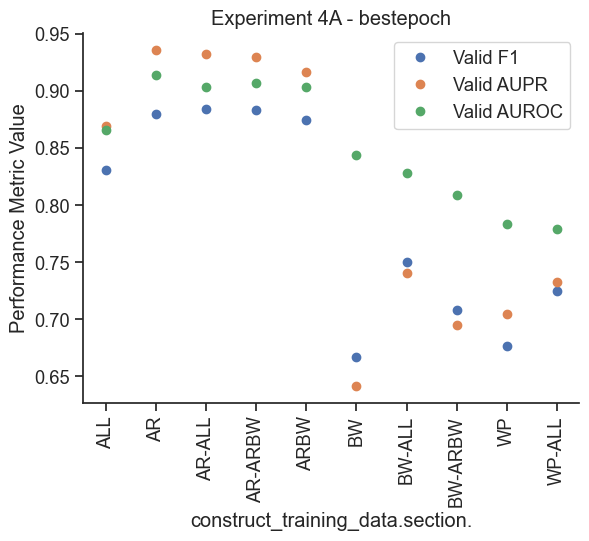

In [7]:
modeltype = 'bestepoch'
key = (modeltype, 'valid')
dfdata = {
    'Factor': factor_labels,
    'Valid Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Valid Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Valid F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Valid AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Valid AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
}

valid = pd.DataFrame(dfdata)

key = (modeltype, 'test')
dfdata = {
#     'Factor': experiment['labels'],
    'Test Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Test Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Test F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Test AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Test AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
}

test = pd.DataFrame(dfdata)

plotdata = valid.sort_values(by=['Factor'])

sns.set(style='ticks', font_scale=1.2)

for col in ('Valid F1', 'Valid AUPR', 'Valid AUROC'):
    plt.plot(range(len(valid)), plotdata[col], 'o', label=col)

plt.xticks(ticks = range(len(valid)), labels = plotdata['Factor'], rotation=90)
plt.xlabel(experiment['factor'])
plt.ylabel('Performance Metric Value')
plt.title(f"Experiment {experiment_id} - {modeltype}")
plt.legend()
sns.despine()

plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}-summary-stats.pdf')

pd.concat([valid, test], axis=1)

,Factor,Valid Precision,Valid Recall,Valid F1,Valid AUPR,Valid AUROC,Test Precision,Test Recall,Test F1,Test AUPR,Test AUROC
0,AR,0.920,0.855,0.887,0.940,0.917,0.907,0.846,0.876,0.921,0.901
1,BW,0.800,0.600,0.686,0.623,0.844,0.792,0.576,0.667,0.647,0.811
2,WP,0.749,0.655,0.699,0.721,0.793,0.642,0.601,0.620,0.623,0.756
3,ALL,0.874,0.801,0.836,0.877,0.881,0.893,0.746,0.813,0.849,0.859
4,AR-ALL,0.932,0.853,0.891,0.940,0.916,0.938,0.838,0.885,0.924,0.900
5,BW-ALL,0.750,0.750,0.750,0.748,0.853,1.000,0.667,0.800,0.696,0.796
6,WP-ALL,0.811,0.655,0.725,0.737,0.800,0.741,0.573,0.647,0.650,0.748
7,ARBW,0.904,0.849,0.876,0.923,0.911,0.917,0.832,0.872,0.909,0.898
8,AR-ARBW,0.915,0.858,0.886,0.936,0.913,0.925,0.838,0.879,0.924,0.899
9,BW-ARBW,0.727,0.667,0.696,0.685,0.825,0.765,0.619,0.684,0.574,0.764


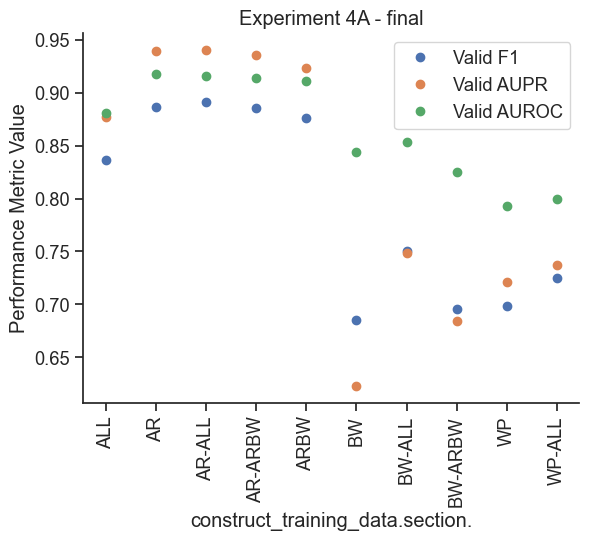

In [8]:
modeltype = 'final'
key = (modeltype, 'valid')
dfdata = {
    'Factor': factor_labels,
    'Valid Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Valid Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Valid F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Valid AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Valid AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
}

valid = pd.DataFrame(dfdata)

key = (modeltype, 'test')
dfdata = {
#     'Factor': experiment['labels'],
    'Test Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Test Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Test F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Test AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Test AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
}

test = pd.DataFrame(dfdata)

plotdata = valid.sort_values(by=['Factor'])

sns.set(style='ticks', font_scale=1.2)

for col in ('Valid F1', 'Valid AUPR', 'Valid AUROC'):
    plt.plot(range(len(valid)), plotdata[col], 'o', label=col)

plt.xticks(ticks = range(len(valid)), labels = plotdata['Factor'], rotation=90)
plt.xlabel(experiment['factor'])
plt.ylabel('Performance Metric Value')
plt.title(f"Experiment {experiment_id} - {modeltype}")
plt.legend()
sns.despine()

plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}-summary-stats.pdf')


pd.concat([valid, test], axis=1)

In [9]:
for fn in experiment['epochperf']:
    df = pd.read_csv(os.path.join('..', fn))
    print(fn, np.argmin(df['valid_loss']))

./results/epoch-results-CB_14-AR-125-all_222_24_25_1e-06_256_32.csv 9
./results/epoch-results-CB_14-BW-125-all_222_24_25_1e-06_256_32.csv 10
./results/epoch-results-CB_14-WP-125-all_222_24_25_1e-06_256_32.csv 4
./results/epoch-results-CB_14-ALL-125-all_222_24_25_1e-06_256_32.csv 7
./results/epoch-results-CB_14-ARBW-125-all_222_24_25_1e-06_256_32.csv 8
